# Transformer (Machine Translation Example)

Transformer is SOTA (state-of-the-art) model and used in today's a lot of successful works in neural methods.<br>
Finally I'll implement transformer using previously learned architectures - such as, language modeling, encoder-decoder, and attention.

As you saw in [exercise 08](./08_attention.ipynb), attention captures the distant relationship and contexts in sequences.<br>
Transformer is motivated by this successful architecture.

![Attention](./images/attend_image.png)<br>
*From : "08 Attention (Machine Translation Example)"*

In the famous paper "[Attention Is All You Need](https://arxiv.org/abs/1706.03762)", attention is also used even for getting contexts in encoder and decoder, instead of using RNN architecture. (As you saw in [exercise 08](./08_attention.ipynb), we have used RNN architecture (GRU gate) for getting contexts in encoder and decoder. In below architecture, there's no RNN layers.)<br>
Total 3 attend layers (encoder's self-attention, decoder's self-attention, and encoder-decoder attention) are then applied in this network.

![Transformer](./images/transformer.png)<br>
*From : "[Attention Is All You Need](https://arxiv.org/abs/1706.03762)" (Vaswani, et al., 2017)*

In these 3 parts of attend layers, unlike soft attention in [exercise 08](./08_attention.ipynb), it applies the following attention, which is called "**scaled dot-product attention**".<br>
As you can see below, this model measures the similarity by the dot-product operation, and only 3 networks for composing query, key, and value will be trained. When the query vector and key vector are similar, it will have a large value of dot product between these vectors. Such like soft attention (in [exercise 08](./08_attention.ipynb)), the matrix $Q \cdot K^T$ will then have the relationship mapping (weight's mapping) between input1's query and input2's key. Finally, by applying dot-product operation again between this result's vector and value vector, the final feature vectors will be obtained in each token.<br>
To say intuitively, first dot-product operation asks each keys by queries in the sequence, and then composes the objectives by combining between its results and values by the second dot-product operation.

![Multi-head attention](./images/multi_head_attention.png)

In the attend layer in encoding and decoding (see below), input1 and input2 are the same sequence. This architecture is called **self-attention**.<br>
For instance, the word "this" in "this is a pen" will have the close relationship with the word "pen". The self-attention captures this kind of self-regressive relations in the sequence.<br>
By capturing these relations, the sequence will be well annotated in encoder and decoder, instead of using RNN layer.

![Self-attention parts](./images/transformer_self_attention.png)

> Note : In the attention layer in decoder, each time segment should not refer to the future segment. It then applies the masked attention, instead of applying fully-connected attention. (See below code for details.)

In this tutorial, we'll see the implementation of each part in this transofrmer architecture, and train the model for machine translation task.<br>
For your learning purpose, I'll implement attention layer from scratch.

By the design of this architecture, transformers will have the ability to capture the distant contexts and we can also expect to have the ability to capture more difficult contexts rather than RNN-based encoder-decoder. As I have mentioned above, transformer is today's key part in SOTA (state-of-the-art) language models and a lot of today's famous algorithms (such as, BERT, T5, GPT, etc) use transformers in its model architectures.<br>
As you saw in [basic language model's example](./05_language_model_basic.ipynb), you can also apply unsupervised approach - such as, next word's prediction, masked word's prediction - in this transformer architecture. By this unsupervised way, a lot of today's algorithms learn a lot of language properties with large corpus, and these can then be fine-tuned for specific downstream tasks with only small amount of labeled data by transfer approach.

*back to [index](https://github.com/tsmatz/nlp-tutorials/)*

In [ ]:
!pip install tensorflow==2.6.2 numpy nltk matplotlib

## Prepare data

In this example, I use Engligh-French dataset by [Anki](https://www.manythings.org/anki/).

In [ ]:
!wget http://www.manythings.org/anki/fra-eng.zip

In [ ]:
!unzip fra-eng.zip -d fra-eng

In [5]:
!head -n 5 fra-eng/fra.txt

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Go.	Marche.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)
Go.	En route !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)
Go.	Bouge !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)


In [6]:
!wc -l fra-eng/fra.txt

197463 fra-eng/fra.txt


In [1]:
from pathlib import Path
import numpy as np

pathobj = Path("fra-eng/fra.txt")
text_all = pathobj.read_text(encoding="utf-8")
lines = text_all.splitlines()
train_data = [line.split("\t") for line in lines]
train_data = np.array(train_data)[:,[1,0]]
# print first row
train_data[0]

array(['Va !', 'Go.'], dtype='<U349')

In this training set, text length in the latter part is longer (and includes multiple sentences) than the former part.<br>
Therefore I shuffle entire data.

In [2]:
np.random.shuffle(train_data)
train_data[0]

array(['Il y a quelques années, je me suis inscrit dans une salle de sport pour perdre du poids.',
       'I joined a gym a few years back to lose weight.'], dtype='<U349')

When data consists of multiple sentences, it converts to a single sentence.

In [3]:
import nltk
import nltk.data

nltk.download("punkt")
tokenizer_en = nltk.data.load("tokenizers/punkt/english.pickle")
tokenizer_fr = nltk.data.load("tokenizers/punkt/french.pickle")
fr_list = []
en_list = []
for x in train_data:
    x1 = tokenizer_fr.tokenize(x[0])
    x2 = tokenizer_en.tokenize(x[1])
    if len(x1) == len(x2):
        fr_list += x1
        en_list += x2
train_data = np.column_stack((fr_list, en_list))

[nltk_data] Downloading package punkt to /home/tsmatsuz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


To get the better performance (accuracy), I standarize the input text as follows.
- Make all words to lowercase in order to reduce words
- Make "-" (hyphen) to space
- Remove all punctuation except " ' " (e.g, Ken's bag, ces't, ...)

> Note : To make simplify, I have skipped other pre-processing, such as, N-gram detection (see [this example](./04_ngram_cnn.ipynb)), polysemy processing, etc.

In [4]:
import string

train_data = np.char.lower(train_data)
train_data = np.char.replace(train_data, "-", " ")
for x in string.punctuation.replace("'", ""):
    train_data = np.char.replace(train_data, x, "")
for x in "«»":
    train_data = np.char.replace(train_data, x, "")
train_data = np.char.strip(train_data)
# print first row
train_data[0]

array(['il y a quelques années je me suis inscrit dans une salle de sport pour perdre du poids',
       'i joined a gym a few years back to lose weight'], dtype='<U250')

Add ```[START]``` and ```[END]``` tokens in string.

In [5]:
train_data = np.array([[" ".join(["[START]", x, "[END]"]), " ".join(["[START]", y, "[END]"])] for x, y in train_data])
# print first row
train_data[0]

array(['[START] il y a quelques années je me suis inscrit dans une salle de sport pour perdre du poids [END]',
       '[START] i joined a gym a few years back to lose weight [END]'],
      dtype='<U264')

## Generate sequence inputs

We will generate the sequence of word's indices (i.e, tokenize) from text.

![Index vectorize](images/index_vectorize2.png?raw=true)

First, we build word's vectorizer for both source text (French) and target text (English) respectively.

In [6]:
import tensorflow as tf

max_word = 10000
source_seq_len = 45
target_seq_len = 38

source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_word,
    output_sequence_length=source_seq_len, # maximum length of sequences
    output_mode="int")
source_vectorization.adapt(train_data[:,0])

target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_word,
    output_sequence_length=target_seq_len, # maximum length of sequences
    output_mode="int")
target_vectorization.adapt(train_data[:,1])

Now we vectorize sentence into integer's sequence as follows.<br>
In this example, we create fixed size of sequence (padded by 0) in each row.

![Index vectorize](images/index_vectorize2.png?raw=true)

In [7]:
train_source = source_vectorization(train_data[:,0])
train_target = target_vectorization(train_data[:,1])
# print first row
print(train_source[0])
print(train_target[0])

tf.Tensor(
[   3   14   51   18  202  795    4   27   25 6076   32   23  899    5
 1305   26  546   42  832    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(45,), dtype=int64)
tf.Tensor(
[   2    4 2584    8 2895    8  289  259  117    6  524  768    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)


Make TensorFlow dataset.

In [8]:
train_tf_data = tf.data.Dataset.from_tensor_slices((train_source, train_target))

Now we generate label (y) for training.

We should finally predict the next word in target sentence (English).<br>
We then create the following label (y) in each row.

<u>input - list of current words</u> :
```
[2, 7, 5, 3, 0, ... , 0]
```

<u>output (y) - list of next words</u> :
```
[7, 5, 3, 0, 0, ... , 0]
```

In [9]:
def add_label(x_source, x_target):
    y = tf.slice(x_target, begin=[1], size=[len(x_target) - 1])
    y = tf.concat([y, [0]], axis=0)
    return (x_source, x_target), y
train_tf_data = train_tf_data.map(lambda src, tar: add_label(src, tar))
# print first row
for x, y in train_tf_data.take(1):
    print("***** X *****")
    print(x)
    print("***** y *****")
    print(y)

***** X *****
(<tf.Tensor: shape=(45,), dtype=int64, numpy=
array([   3,   14,   51,   18,  202,  795,    4,   27,   25, 6076,   32,
         23,  899,    5, 1305,   26,  546,   42,  832,    2,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])>, <tf.Tensor: shape=(38,), dtype=int64, numpy=
array([   2,    4, 2584,    8, 2895,    8,  289,  259,  117,    6,  524,
        768,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])>)
***** y *****
tf.Tensor(
[   4 2584    8 2895    8  289  259  117    6  524  768    3    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)


Now we convert label y into one-hot vector (shape (max_word,)).

y (before) :
```
[4, 1, 3, 0]
```

y (after) :
```
[
  [0,0,0,0,1, ... ,0],
  [0,1,0,0,0, ... ,0],
  [0,0,0,1,0, ... ,0],
  [1,0,0,0,0, ... ,0]
]
```

In [10]:
def to_one_hot(x, y):
    y_new = tf.one_hot(y, depth=max_word)
    return x, y_new
train_tf_data = train_tf_data.map(lambda x, y: to_one_hot(x, y))
# print y in first row
for x, y in train_tf_data.take(1):
    print(y)

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]], shape=(38, 10000), dtype=float32)


## Positional Encoding

In the formal algorithms of transformer, the set of embedded tokens are encoded by positions without any additional parameters.

![Positional encoding](./images/transformer_positional_encoding.png)

If there's no positional encoding, the sequence will be treated as a bag of tokens in neural networks. The positional information is needed for position-aware processing in attention.

There exist several ways (variations) for positional encoding.<br>
In this example, I'll apply the following positional encoding method (called **sinusoidal positional encoding**), which is introduced in the [original paper](https://arxiv.org/abs/1706.03762) of transformer.

1. The positional vector $PE(t)$ is :<br>
$ PE(t,2i) = \sin(t / 10000^{2i / d_e}) $<br>
$ PE(t,2i+1) = \cos(t / 10000^{2i / d_e}) $<br>
for $0 \leq i \lt d_e / 2$<br>
where $t = \{0, 1, \ldots\}$ is position and $d_e$ is embedding dimemsion.
2. For $t$-th token of the sequence, the embedding $E(t) \in \mathbb{R}^{d_e}$ then becomes $ E(t) + PE(t) $.

> Note : Here we assume that $d_e$ (embedding dimension) is an even number. (When it's an odd number, the dimension between $E(t)$ and $PE(t)$ differs.)

By applying this positional encoding, we can expect that the attention network will easily learn the position in each tokens, since there always exist a $ 2 \times 2 $ matrix $\mathbf{M}_{ik}$ (depending on $i$ and $k$) which satisfies

$$ \begin{pmatrix} PE(t+k,2i)\\PE(t+k,2i+1) \end{pmatrix} = \mathbf{M}_{ik} \begin{pmatrix} PE(t,2i)\\PE(t,2i+1) \end{pmatrix} $$

for any $t$.

In [11]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, seq_len, embedding_dim, **kwargs):
        assert(embedding_dim % 2 == 0)

        super().__init__()
        # 1 / 10000^{2i / d_e} - Shape is (embedding_dim / 2, )
        interval = 1.0 / (10000**(tf.range(0, embedding_dim, 2.0) / embedding_dim))
        # t - Shape is (seq_len, )
        position = tf.cast(tf.range(0, seq_len), tf.float32)
        # t / 10000^{2i / d_e} - Shape is (seq_len, embedding_dim / 2)
        radian = position[:, None] * interval[None, :]
        # sin(t / 10000^{2i / d_e}) - Shape is (seq_len, embedding_dim / 2, 1)
        sin = tf.expand_dims(tf.sin(radian), -1)
        # cos(t / 10000^{2i / d_e}) - Shape is (seq_len, embedding_dim / 2, 1)
        cos = tf.expand_dims(tf.cos(radian), -1)
        # PE - Shape is (seq_len, embedding_dim / 2, 2)
        pe_tmp =  tf.concat((sin, cos), axis=-1)
        # Reshape PE - Shape is (seq_len, embedding_dim)
        s = pe_tmp.shape[0]
        d = pe_tmp.shape[1]
        self.pe = tf.reshape(pe_tmp, [s, d * 2])

    # This method is needed to support masking in outputs.
    # see https://www.tensorflow.org/guide/keras/masking_and_padding
    def compute_mask(self, inputs, mask=None):
        return inputs._keras_mask

    def call(self, inputs):
        return inputs + self.pe

Now let's test the output of positional encoding layer.<br>
In the following example, positional vectors will become :

```
[
  [sin(0), cos(0), sin(0/100), cos(0/100)],
  [sin(1), cos(1), sin(1/100), cos(1/100)],
  [sin(2), cos(2), sin(2/100), cos(2/100)],
]
```

In [12]:
test = PositionalEncoding(3, 4)
print("##### positional vector #####")
print(test.pe)
# The input shape is [batch_size, seq_len, embedding_dim]
x = tf.constant([
    [[1.0, 2.0, 3.0, 4.0], [5.0, 6.0, 7.0, 8.0], [9.0, 10.0, 11.0, 12.0]],
    [[13.0, 14.0, 15.0, 16.0], [17.0, 18.0, 19.0, 20.0], [21.0, 22.0, 23.0, 24.0]]
], dtype=tf.float32)
mask = tf.keras.layers.Masking(mask_value=0., input_shape=(3, 4))
x = mask(x)
y = test(x)
print("##### output #####")
print(y)

##### positional vector #####
tf.Tensor(
[[ 0.          1.          0.          1.        ]
 [ 0.841471    0.5403023   0.00999983  0.99995   ]
 [ 0.90929747 -0.4161468   0.01999867  0.9998    ]], shape=(3, 4), dtype=float32)
##### output #####
tf.Tensor(
[[[ 1.         3.         3.         5.       ]
  [ 5.841471   6.5403023  7.0099998  8.99995  ]
  [ 9.909298   9.583853  11.019999  12.9998   ]]

 [[13.        15.        15.        17.       ]
  [17.84147   18.540302  19.01      20.99995  ]
  [21.909298  21.583853  23.019999  24.9998   ]]], shape=(2, 3, 4), dtype=float32)


##  Multi-head and Scaled Dot-Product Attention

Next I'll implement attention layer as follows.<br>
For the purpose of your learning, I'll implement the scaled dot-product attention layer from scratch, but you can use built-in ```tf.keras.layers.MultiHeadAttention()``` for multi-head attention implementation in TensorFlow.

For the semantics of this model, see above description.

To make multiple attention work in parallel, model dimension (here 256) is divided into multiple heads (here 8), and each head will then have ```model_dim / head_num``` dimension (here 32). (Finally, these separated heads are concatenated and then applied dense network to obtain model dimension's result.)<br>
This technique will make our model have rich expression without losing the computing costs.

![Multi-head attention](./images/transformer_attention.png)

> Note : I'll describe the purpose of ```use_causal_mask``` property later (which is used in decoder).

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """Initializes a MultiHeadAttention keras Layer object.

    Args:
        attention_dim (int): The dimension within attention unit.
        use_causal_mask (bool): Whether to mask the future tokens.
            (This will be enabled in decoder side.)
        **kwargs:
    """
    def __init__(self, attention_dim, num_heads, use_causal_mask=False, **kwargs):
        assert(attention_dim % num_heads == 0)
        self.num_heads = num_heads
        self.attention_dim = attention_dim
        self.head_dim = int(attention_dim / num_heads)
        self.use_causal_mask = use_causal_mask
        self.q_layer = tf.keras.layers.Dense(
            attention_dim, name="q")
        self.k_layer = tf.keras.layers.Dense(
            attention_dim, name="k")
        self.v_layer = tf.keras.layers.Dense(
            attention_dim, name="v")
        self.softmax = tf.keras.layers.Softmax(
            axis=2
        )
        self.output_linear = tf.keras.layers.Dense(
            attention_dim, use_bias=False, name="o")
        super().__init__()

    # This method is needed to support masking in outputs.
    # see https://www.tensorflow.org/guide/keras/masking_and_padding
    def compute_mask(self, inputs, mask=None):
        return inputs._keras_mask

    def call(self, inputs, input2=None, training=False):
        input1 = inputs
        if input2 is None:
            input2 = input1

        batch_size = tf.shape(input1)[0]
        seq_len1 = tf.shape(input1)[1]
        seq_len2 = tf.shape(input2)[1]

        # Apply query/key/value net
        q = self.q_layer(input1, training=training)
        k = self.k_layer(input2, training=training)
        v = self.v_layer(input2, training=training)

        # Divide shape [batch_size, seq_len, attention_dim] into [batch_size, seq_len, num_heads, attention_dim / num_heads]
        q = tf.reshape(q, [-1, seq_len1, self.num_heads, self.head_dim])
        k = tf.reshape(k, [-1, seq_len2, self.num_heads, self.head_dim])
        v = tf.reshape(v, [-1, seq_len2, self.num_heads, self.head_dim])

        # Q K^T
        score = tf.einsum("bihd,bjhd->bijh", q, k)
        
        # Q K^T * 1/sqrt(d)
        score = score / self.head_dim**0.5

        # Generate mask for applying
        # (mask shape becomes [seq_len1, seq_len2])
        if self.use_causal_mask:
            # Note : when use_causal_mask=True, the shape of input1 should be same as input2
            assert(seq_len1 == seq_len2)
            mask = tf.sequence_mask(
                lengths=tf.range(1, seq_len1 + 1),
                maxlen=seq_len1,
                dtype=tf.float32)
        else:
            mask = tf.fill([seq_len1, seq_len2], 1.0)
        # (mask shape becomes [batch_size, seq_len1, seq_len2, num_heads])
        mask = tf.expand_dims(mask, axis=0)
        mask = tf.expand_dims(mask, axis=3)
        mask = tf.tile(mask, [batch_size, 1, 1, self.num_heads])
        # (add masking for input2 sequence)
        input2_mask = input2._keras_mask # shape [batch_size, seq_len2]
        input2_mask = tf.cast(input2_mask, tf.float32)
        input2_mask = tf.expand_dims(input2_mask, axis=1) # shape [batch_size, 1, seq_len2]
        input2_mask = tf.expand_dims(input2_mask, axis=3) # shape [batch_size, 1, seq_len2, 1]
        input2_mask = tf.tile(input2_mask, [1, seq_len1, 1, self.num_heads]) # shape [batch_size, seq_len1, seq_len2, num_heads]
        mask = tf.math.multiply(mask, input2_mask)

        # Apply softmax (on axis 2) : softmax(Q K^T * 1/sqrt(d))
        wmat = self.softmax(
            inputs=score,
            mask=mask,
        )

        # Softmax(Q K^T * 1/sqrt(d)) V
        out = tf.einsum("bijh,bjhd->bihd", wmat, v)

        # Concatenate all heads and apply linear
        out = tf.reshape(out, [batch_size, seq_len1, self.attention_dim])
        out = self.output_linear(out)

        return out

## Encoder

Now let's implement encoder side with previously generated layers.<br>
Same as [exercise 08](./08_attention.ipynb), the purpose of encoder is to generate the contexts of source sequence (French text). However, unlike exercise 08, we don't use RNN (GRU) and apply the scaled dot-product attention (self-attention) instead.

![Transformer](./images/transformer.png)

As you can see above, the encoder in transformer (left side in above picture) has the repeated layers. (In above picture, it shows with "Nx".)<br>
For this reason, we'll first implement the following repeated layer component.

![Encoding Layer](./images/transformer_encoding_layer.png)

> Note : As you can see above, it adds an output of identity layer (which is written by "Add" in above picture) in the end of each layers. This is a known architecture called **residual learning** to address a degradation problem of training accuracy by deep neural networks.<br>
> See "[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)" (He, et al., 2015) for details.

> Note : I also add a dropout for regularization in the following code. (For the effect of a dropout, see [here](https://tsmatz.wordpress.com/2017/09/13/overfitting-for-regression-and-deep-learning/).)

In [14]:
class SingleEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, seq_len, model_dim, num_heads, hidden_dim, **kwargs):
        super().__init__()
        self.self_attention = MultiHeadAttention(
            attention_dim=model_dim,
            num_heads=num_heads,
        )
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.add = tf.keras.layers.Add()
        self.norm = tf.keras.layers.LayerNormalization(axis=-1)
        self.output_dense1 = tf.keras.layers.Dense(
            hidden_dim,
            activation="relu",
        )
        self.output_dense2 = tf.keras.layers.Dense(
            model_dim,
            activation=None,
        )

    # This method is needed to support masking in outputs.
    # see https://www.tensorflow.org/guide/keras/masking_and_padding
    def compute_mask(self, inputs, mask=None):
        return inputs._keras_mask

    # This method keeps input's masking ...
    def call(self, inputs, training=False):
        # Attention
        attention_outputs = self.self_attention(inputs, training=training)
        # Add & Layer norm (with dropout)
        attention_outputs = self.dropout(attention_outputs)
        attention_outputs = self.add([attention_outputs, inputs])
        attention_outputs = self.norm(attention_outputs)
        # Feed Forward
        outputs = self.output_dense1(attention_outputs, training=training)
        outputs = self.output_dense2(outputs, training=training)
        # Add & Layer norm (with dropout)
        outputs = self.dropout(outputs)
        outputs = self.add([outputs, attention_outputs])
        outputs = self.norm(outputs)

        return outputs

With previously generated component (```SingleEncodingLayer```), now we implement the encoder as follows.

![Encoding Layer](./images/transformer_encoder.png)

In [15]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, seq_len, model_dim, num_layers, num_heads, hidden_dim, **kwargs):
        super().__init__()
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(
            vocab_size,
            model_dim,
            mask_zero=True,
            trainable=True,
        )
        self.pos_encoding = PositionalEncoding(
            seq_len=seq_len,
            embedding_dim=model_dim,
        )
        self.encoding_layers = [
            SingleEncodingLayer(
                seq_len=seq_len,
                model_dim=model_dim,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
            )
            for _ in range(num_layers)]

    # This method keeps input's masking ...
    def call(self, source_inputs, training=False):
        # Embedding
        outputs = self.embedding(source_inputs, training=training)
        # Positional encoding
        outputs = self.pos_encoding(outputs, training=training)
        # Apply SingleEncodingLayer (multiple times)
        for i in range(self.num_layers):
            outputs = self.encoding_layers[i](outputs, training=training)

        return outputs

## Decoder

Next implement decoder side.<br>
Same as encoder, we'll first implement the repeated layer component as the following picture shows.

![Decoding Layer](./images/transformer_decoding_layer.png)

However, in the self-attention layer in decoder, i-th token should be attended by tokens 1, 2, ... , i - 1 (because the decoder doesn't know future words) unlike encoder side, and it should then set the property ```use_causal_mask=True```.

In the next encoder-decoder attention, the attended output will then be generated by feeding both encoder's outputs and decoder's outputs. (As I have described in [exercise 08](./08_attention.ipynb), we need the attended output between encoder and decoder.)

In [16]:
class SingleDecodingLayer(tf.keras.layers.Layer):
    def __init__(self, seq_len, model_dim, num_heads, hidden_dim, **kwargs):
        super().__init__()
        self.self_attention = MultiHeadAttention(
            attention_dim=model_dim,
            num_heads=num_heads,
            use_causal_mask=True,
        )
        self.cross_attention = MultiHeadAttention(
            attention_dim=model_dim,
            num_heads=num_heads,
        )
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.add = tf.keras.layers.Add()
        self.norm = tf.keras.layers.LayerNormalization(axis=-1)
        self.feed_dense1 = tf.keras.layers.Dense(
            hidden_dim,
            activation="relu",
        )
        self.feed_dense2 = tf.keras.layers.Dense(
            model_dim,
            activation=None,
        )

    # This method is needed to support masking in outputs.
    # see https://www.tensorflow.org/guide/keras/masking_and_padding
    def compute_mask(self, inputs, mask=None):
        return inputs._keras_mask

    # This method keeps target input's masking ...
    def call(self, inputs, enc_outputs, training=False):
        # Self-attention
        attention_outputs = self.self_attention(inputs, training=training)
        # Add & Layer norm (with dropout)
        attention_outputs = self.dropout(attention_outputs)
        attention_outputs = self.add([attention_outputs, inputs])
        attention_outputs = self.norm(attention_outputs)
        # Encoder-decoder attention
        scored_outputs = self.cross_attention(
            attention_outputs,
            input2=enc_outputs,
            training=training,
        )
        # Add & Layer norm (with dropout)
        scored_outputs = self.dropout(scored_outputs)
        scored_outputs = self.add([scored_outputs, attention_outputs])
        scored_outputs = self.norm(scored_outputs)
        # Feed Forward
        outputs = self.feed_dense1(scored_outputs, training=training)
        outputs = self.feed_dense2(outputs, training=training)
        # Add & Layer norm (with dropout)
        outputs = self.dropout(outputs)
        outputs = self.add([outputs, scored_outputs])
        outputs = self.norm(outputs)

        return outputs

Now we build decoder with previous layer component (```SingleDecodingLayer```).

![Decoder](./images/transformer_decoder.png)

The outputs is used for predicting the next vocabulary by one-hot outputs, and the output's shape will then be ```(batch_size, sequence_length, vocabulary_size)```.

> Note : In this example, the final softmax will be applied in loss computation, and here I don't implement this layer. (The decoder will then output logits.)

In [17]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, seq_len, model_dim, num_layers, num_heads, hidden_dim, **kwargs):
        super().__init__()
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(
            vocab_size,
            model_dim,
            mask_zero=True,
            trainable=True,
        )
        self.pos_encoding = PositionalEncoding(
            seq_len=seq_len,
            embedding_dim=model_dim,
        )
        self.decoding_layers = [
            SingleDecodingLayer(
                seq_len=seq_len,
                model_dim=model_dim,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
            )
            for _ in range(num_layers)]
        self.output_dense = tf.keras.layers.Dense(
            vocab_size,
            activation=None,
        )

    # This method keeps target input's masking ...
    def call(self, target_inputs, enc_outputs, training=False):
        # Embedding
        outputs = self.embedding(target_inputs, training=training)
        # Positional encoding
        outputs = self.pos_encoding(outputs, training=training)
        # Apply SingleEncodingLayer (multiple times)
        for i in range(self.num_layers):
            outputs = self.decoding_layers[i](outputs, enc_outputs, training=training)
        # Linear
        # (batch_size, seq_len, model_dim) -> (batch_size, seq_len, vocab_size)
        outputs = self.output_dense(outputs, training=training)

        return outputs

## Train Model (Transformer)

Using previous models, now we build the training loop.

First we set the following parameters for training.<br>
In this example, the training dataset consists of single sentences (i.e, not so long and difficult text) and I have reduced parameters to speed up the training, compared with the parameters which is used in the original paper.

> Note : By increasing parameters, transformers will have the ability to capture more difficult contexts, but it'll need more training and corpus.

In [18]:
model_dim = 256
num_heads = 8
num_layers = 4
hidden_dim = 1024

### In the original paper, the following parameters are used.
#model_dim = 512
#num_heads = 8
#num_layers = 6
#hidden_dim = 2048

In the original paper, the following step-to-step learning rate is used for this model.

$$ \verb|lrate| = d^{-0.5}_{\verb|model|} \cdot \min(\verb|step_num|^{-0.5},\verb|step_num|\cdot\verb|warmup_steps|^{-1.5}) $$

So we will also use the same progressive learning rate.

In [19]:
# See https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule
class TransformerLRScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, model_dim, warmup_steps=4000):
        self.model_dim = float(model_dim)
        self.warmup_steps = float(warmup_steps)
    def __call__(self, step):
        step = float(step)
        if step == 0.0:
            val1 = 0.0
        else:
            val1 = 1.0 / (step ** 0.5)
        val2 = step / (self.warmup_steps ** 1.5)
        return min(val1,val2) / (self.model_dim ** 0.5)

learning_rate = TransformerLRScheduler(model_dim)

Now, put it all together and run training as follows.

In [20]:
import numpy as np

n_epoch = 15
shuffle_buffer_size = 5000
train_batch_size = 32
loss_records = []

enc_model = Encoder(
    vocab_size=max_word,
    seq_len=source_seq_len,
    model_dim=model_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
)
dec_model = Decoder(
    vocab_size=max_word,
    seq_len=target_seq_len,
    model_dim=model_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    hidden_dim=hidden_dim,
)
loss_func = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.NONE
)
opt = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9)

### I don't use train_tf_data.repeat(n_epoch) and run shuffle in each epoch,
### because I want to check result in each epoch
for epoch in range(n_epoch):
    tf_data_epoch = train_tf_data.shuffle(shuffle_buffer_size).batch(train_batch_size)
    iterator = iter(tf_data_epoch)
    while True:
        with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape:
            # get next batch
            try:
                input_batch_x, input_batch_y = iterator.get_next()
            except tf.errors.OutOfRangeError:
                loop_f = False
                break
            input_source, input_target = input_batch_x
            # process encoder
            enc_outputs = enc_model(
                source_inputs=input_source,
                training=True)
            # process decoder
            logits = dec_model(
                target_inputs=input_target,
                enc_outputs=enc_outputs,
                training=True)
            # calculate masked loss
            loss = loss_func(
                input_batch_y,
                logits) # shape of loss is (batch_size, sequence_size)
            mask_float = tf.cast(logits._keras_mask, tf.float32) # True -> 1.0, False -> 0.0
            loss = loss * mask_float
            loss = tf.math.reduce_sum(loss, axis=1) # shape of loss is (batch_size, )
            loss = loss / tf.math.reduce_sum(mask_float, axis=1)
            # get gradient
            grad = enc_tape.gradient(
                loss,
                enc_model.trainable_variables+dec_model.trainable_variables
            )
        # apply gradient
        opt.apply_gradients(zip(grad, enc_model.trainable_variables+dec_model.trainable_variables))
        # record result
        batch_average_loss = tf.math.reduce_mean(loss).numpy().tolist()
        print("Epoch {}/{} - loss {loss:10.6f}".format(epoch+1, n_epoch, loss=batch_average_loss), end="\r")
        loss_records.append(batch_average_loss)
    # output last 100 loss average in epoch
    print("Epoch {}/{} - loss {loss:10.6f}".format(epoch+1, n_epoch, loss=np.average(loss_records[-100:])), end="\r")
    # add line break
    print("")

Epoch 1/15 - loss   2.953753
Epoch 2/15 - loss   2.208414
Epoch 3/15 - loss   1.918675
Epoch 4/15 - loss   1.712586
Epoch 5/15 - loss   1.688345
Epoch 6/15 - loss   1.619679
Epoch 7/15 - loss   1.599739
Epoch 8/15 - loss   1.561381
Epoch 9/15 - loss   1.461882
Epoch 10/15 - loss   1.493265
Epoch 11/15 - loss   1.454271
Epoch 12/15 - loss   1.449514
Epoch 13/15 - loss   1.378832
Epoch 14/15 - loss   1.379176
Epoch 15/15 - loss   1.371115


After the training has completed, show how loss is optimized.

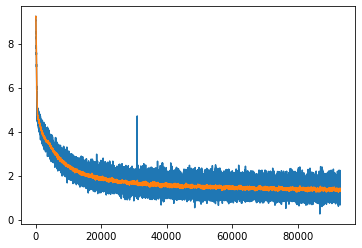

In [21]:
import numpy as np
import matplotlib.pyplot as plt

#loss_list = loss_records[:10000]
loss_list = loss_records

loss_average = []
for i in range(len(loss_list)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if i < 50:
        avg_list = loss_list[:i+1]
    else:
        avg_list = loss_list[i-49:i+1]
    loss_average.append(np.average(avg_list))
plt.plot(loss_list)
plt.plot(loss_average)

## Translate Text

Now translate French text to English text with trained model. (All these sentences are not in training set.)

Here I simply translate several brief sentences, but the metrics to evaluate text-generation task will not be so easy. (Because simply checking an exact match to a reference text is not optimal.)<br>
To eveluate the trained model, use some common metrics available in text generation, such as, BLEU or ROUGE.

> Note : Here I use greedy search and this will sometimes lead to wrong sequence. For drawbacks and solutinos, see note in [this example](./05_language_model_basic.ipynb).

In [22]:
import numpy as np

def translate(sentence):
    # preprocess french
    input_text_fr = sentence
    input_text_fr = input_text_fr.lower()
    input_text_fr = " ".join(["[START]", input_text_fr, "[END]"])

    text_seq_fr = source_vectorization(input_text_fr)
    text_seq_fr = tf.expand_dims(text_seq_fr, axis=0)

    # process encoder
    enc_outputs = enc_model(text_seq_fr)

    # process decoder
    vocab_list_en = target_vectorization.get_vocabulary()
    token_idx = 0
    text_list_en = ["[START]"]
    end_num_en = target_vectorization("[END]").numpy().tolist()[0]
    while True:
        text_seq_en = target_vectorization(" ".join(text_list_en))
        text_seq_en = tf.expand_dims(text_seq_en, axis=0)
        y = dec_model(
            target_inputs=text_seq_en,
            enc_outputs=enc_outputs,
        )
        prev_idx_en = np.argmax(y[0][token_idx])
        if prev_idx_en.item() == end_num_en:
            break
        next_word_en = vocab_list_en[prev_idx_en.item()]
        print(next_word_en, end=" ")
        text_list_en.append(next_word_en)
        token_idx += 1
    print("\n")

In [23]:
translate("j'aime la guitare") # i like guitar
translate("il vit au japon") # he lives in Japan
translate("ce stylo est utilisé par lui") # this pen is used by him
translate("c'est ma chanson préférée") # that's my favorite song
translate("il conduit une voiture et va à new york") # he drives a car and goes to new york

i like guitar 

he lives in japan 

that pen is used to him 

this is my favorite song 

he drives a car and goes to new york 

